In [1]:
import zipfile
path = './spaceship-titanic.zip'
with zipfile.ZipFile(path,'r') as f:
    f.extractall('./')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


spaceship_Titanic =  pd.read_csv('./train.csv')
Submission_data  = pd.read_csv('./test.csv')
spaceship_Target = spaceship_Titanic['Transported']*1
spaceship_Data = spaceship_Titanic.drop('Transported',axis=1)
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

In [3]:
encoded_col = ['HomePlanet','CryoSleep','Destination','VIP','Cabin_deck','Cabin_side']
noencoded_col = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Cabin_num']
temp = spaceship_Data['Cabin'].str.split('/',expand=True)
temp.columns = ['Cabin_deck','Cabin_num','Cabin_side']
temp['Cabin_num'] = temp['Cabin_num'].fillna(temp['Cabin_num'].median())
temp['Cabin_num'] = temp['Cabin_num'].astype(int)
spaceship_data = pd.concat([spaceship_Data,temp],axis=1)
ordinal_encoder = OrdinalEncoder()
scaler = StandardScaler()
spaceship_cat_encoded = pd.DataFrame(ordinal_encoder.fit_transform(spaceship_data[encoded_col]))
spaceship_cat_encoded.columns = encoded_col
spaceship_prepro = pd.concat([spaceship_data[noencoded_col],spaceship_cat_encoded],axis=1)
spaceship_prepro = spaceship_prepro.fillna(spaceship_prepro.median())
X_train,X_test,y_train,y_test = train_test_split(spaceship_prepro,spaceship_Target,test_size=0.2)
X_train,X_valid,y_train,y_valid = train_test_split(X_train,y_train,test_size=0.2)
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_valid = scaler.fit_transform(X_valid)

In [4]:
Submission_feature = Submission_data.drop('PassengerId',axis=1)
encoded_col = ['HomePlanet','CryoSleep','Destination','VIP','Cabin_deck','Cabin_side']
noencoded_col = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Cabin_num']
temp = Submission_feature['Cabin'].str.split('/',expand=True)
temp.columns = ['Cabin_deck','Cabin_num','Cabin_side']
temp['Cabin_num'] = temp['Cabin_num'].fillna(temp['Cabin_num'].median())
temp['Cabin_num'] = temp['Cabin_num'].astype(int)
Submission_feature = pd.concat([Submission_feature,temp],axis=1)
ordinal_encoder = OrdinalEncoder()
submission_cat_encoded = pd.DataFrame(ordinal_encoder.fit_transform(Submission_feature[encoded_col]))
submission_cat_encoded.columns = encoded_col
submission_prepro = pd.concat([Submission_feature[noencoded_col],submission_cat_encoded],axis=1)
submission_prepro = submission_prepro.fillna(submission_prepro.median())
submission_prepro = scaler.fit_transform(submission_prepro)

Epoch 1/1000
11/11 [==============================] - 5s 350ms/step - loss: 0.9946 - accuracy: 0.6827 - val_loss: 4.8762 - val_accuracy: 0.6147
Epoch 2/1000
11/11 [==============================] - 3s 315ms/step - loss: 0.7874 - accuracy: 0.7242 - val_loss: 2.9817 - val_accuracy: 0.7735
Epoch 3/1000
11/11 [==============================] - 3s 300ms/step - loss: 0.6571 - accuracy: 0.7350 - val_loss: 2.6020 - val_accuracy: 0.7728
Epoch 4/1000
11/11 [==============================] - 3s 294ms/step - loss: 0.5655 - accuracy: 0.7550 - val_loss: 1.8655 - val_accuracy: 0.7858
Epoch 5/1000
11/11 [==============================] - 3s 298ms/step - loss: 0.5304 - accuracy: 0.7604 - val_loss: 1.3376 - val_accuracy: 0.7843
Epoch 6/1000
11/11 [==============================] - 3s 277ms/step - loss: 0.5073 - accuracy: 0.7753 - val_loss: 1.8918 - val_accuracy: 0.7692
Epoch 7/1000
11/11 [==============================] - 3s 302ms/step - loss: 0.5049 - accuracy: 0.7690 - val_loss: 0.9270 - val_accuracy:

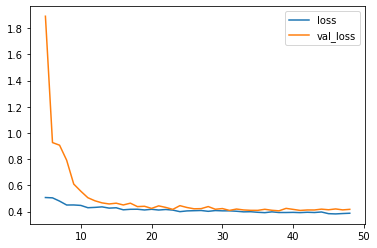

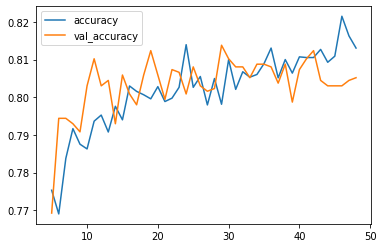

In [13]:
def build_model(n_hidden=1,n_neurons=256,learning_rate=1e-3,dropping_rate=0.5,input_shape=[13],alpha=0.001):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons,activation='relu',
                                     kernel_regularizer=keras.regularizers.l2(alpha),
                                     kernel_initializer='he_normal'))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dropout(dropping_rate))
    model.add(keras.layers.Dense(2,activation='sigmoid'))
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    return model
model = build_model(n_hidden=5,n_neurons=2048,input_shape=X_train.shape[1],alpha=0)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,min_delta=0.001,restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint('space_titanic.h5',save_best_only=True)
history = model.fit(X_train,y_train,epochs=1000,batch_size=512,
                    validation_data=[X_valid,y_valid],
                    callbacks=[early_stopping_cb,checkpoint_cb])
history_df = pd.DataFrame(history.history)
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['accuracy', 'val_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_accuracy'].max()))
print(model.evaluate(X_train,y_train,batch_size=256))
print(model.evaluate(X_test,y_test,batch_size=256))
print(model.evaluate(X_valid,y_valid,batch_size=256))

In [16]:
prediction = pd.concat([Submission_data['PassengerId'],pd.DataFrame(np.argmax(model.predict(submission_prepro),axis=1),columns=['Transported'])],axis=1)
prediction['Transported'] = prediction['Transported'].astype('bool')
display(prediction['Transported'].value_counts(normalize=True).sort_index())

False    0.513444
True     0.486556
Name: Transported, dtype: float64

In [17]:
prediction.to_csv('My_output.csv',index=False)